# Multi Layer Perceptron
### Mehdi Lotfipour

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.gridspec import GridSpec

Fisrt we start by defining mathematical functions.

In [2]:
#sigmoid function
def sigmoid(net, g, a):
    x = net * g * a
    z = (2 * abs(a)) / (1 + np.exp(-x))
    return z

#tanh function
def tanh(net, g, a):
    x = net * g * a
    nominator = 2
    denominator = 1 + np.exp(-2 * x)
    z = (nominator / denominator) - 1
    z *= (1 / a) 
    return z

#identity function
def iden(net):
    return net

#activate w.r.t function type
def activate(activation_func, net, g, a):
    if activation_func == 'sigmoid':
        return sigmoid(net, g, a)
    elif activation_func == 'tanh':
        return tanh(net, g, a)
    elif activation_func == 'iden':
        return iden(net)

#derivative activate w.r.t function type
def activate_der(activation_func, net, g, a, wrt = 'net'):
    #sigmoid derivation
    if activation_func == 'sigmoid':
        z = sigmoid(net, g, a)
        der = z * (1 - z)
        if wrt == 'net':
            return (2 * g * a ** 2) * der
        elif wrt == 'g':
            return (2 * net * a ** 2) * der
        elif wrt == 'a':
            return (2 * net * a * g) * der + (2 * z)
    #tanh derivation
    elif activation_func == 'tanh':
        z = tanh(net, g, a)
        der = (1 - z ** 2)
        if wrt == 'net':
            return g * der
        elif wrt == 'g':
            return net * der * (1/a)
        elif wrt == 'a':
            return der * (net * g / a) + (-z / (a ** 2))
    #identity derivation
    elif activation_func == 'iden':
        return np.ones(net.shape)
    
#softmax function
def softmax(X):
    #X: (d x N)matrix -> d: input dimension & N: number of records
    #softmax(X): (m x N)matrix -> m: output dimension & N: number of records
    z_nom = np.exp(X)
    z_denom = np.einsum('ij->j', z_nom)
    return z_nom / z_denom

#softmax derivation function
def softmax_der(X):
    #X: (d x N)matrix -> d: input dimension & N: number of records
    #softmax_der(X): (m x m x N)tensor -> m: output dimension & N: number of records
    s = softmax(X)
    record_dim = s.shape[0]
    record_len = s.shape[1]
    a = np.zeros([record_dim, record_dim, record_len])
    a[np.arange(record_dim), np.arange(record_dim), :] = s
    b = np.einsum('ik,jk->ijk', s,s)
    return a - b

Here we define two helper function for changing output to classification decision.

In [3]:
def float_classify(prediction):
    centers = np.array([1/6, 3/6, 5/6]).reshape(3,1)
    z = abs(prediction - centers)
    decision = np.argmin(z, axis=0)
    return decision

def onehot_classify(prediction):
    decision = np.argmax(prediction, axis=0)
    return decision

Now we define a class to make a network object. When we initialize a network it keeps prameters and other running network values in itself. We define a network by its structure size, activation function types, learning rates, starting parameter values and limits. After that we define two main function of network:

feed forward

back propagation

they only change state of network and return nothing. In feed forward we find outputs w.r.t input matrix. In back propagation we find error and change parameters w.r.t target matrix and last feed forward step input matrix.

In [4]:
class MLP_NN():
    #wa keep structure and layers of a network in an object of MLP_NN class
    
    #structure is a list of dimensions: [5,3,3,2] means a network with input of dimension 5, two hidden
    #layers of size 3 and an output of two dimension. activate is its type of activation functions in a list
    #etas are learning rates, alpha and beta are momentums constants
    #limits are boundry of first values of W & B
    def __init__(self, structure, activate,
                 eta_W= 0.01, eta_B= 0.01, eta_a= 0, eta_g= 0,
                 w_lower_limit= 0, w_upper_limit= 1, g_first= 1, a_first= 0.5, SM = False):
        #structure is a list of dimensions: [5,3,3,2] means a network with input of dimension 5, two hidden
        #layers of size 3 and an output of two dimension.
        #activate is list of layers activation function type
        #etas are learning rates, alpha and beta are momentums constants
        #limits are boundry of first values of W & B
        #firsts are initial parameter value
        #SM is true if we use softmax in last layer
        
        #structure of network
        #keep details for each layer
        self.SM = SM
        self.act = [0] + activate
        self.structure = structure
        self.max_layer = len(structure) - 1
        #keep matrices of parameters
        self.W = [0] * (self.max_layer + 1)
        self.B = [0] * (self.max_layer + 1)
        self.g = [0] * (self.max_layer + 1)
        self.a = [0] * (self.max_layer + 1)
        self.eta_W = [eta_W] * (self.max_layer + 1)
        self.eta_B = [eta_B] * (self.max_layer + 1)
        self.eta_a = [eta_a] * (self.max_layer + 1)
        self.eta_g = [eta_g] * (self.max_layer + 1)
        #setting starting parameters
        #for each layer
        for i in range(1, self.max_layer + 1):
            #random numbers for first value of weight
            self.W[i] = np.random.uniform(low= w_lower_limit, high= w_upper_limit, size= (structure[i], structure[i-1])) * np.sqrt(2 / structure[i-1])
            #zero numbers for first value of bias
            self.B[i] = np.zeros([structure[i], 1])
            #fix numbers for first value of g & a
            self.g[i] = np.ones([structure[i], 1]) * g_first
            self.a[i] = np.ones([structure[i], 1]) * a_first
    
        #feed forward values
        #keep vectors of outputs & nets
        self.Output = [0] * (self.max_layer + 1)
        self.Net = [0] * (self.max_layer + 1)
        
        #back propagation values
        #keep errors & deltas & sigmas
        self.Error = [0] * (self.max_layer + 1)
        self.delta = [0] * (self.max_layer + 1)
        self.sigma_a = [0] * (self.max_layer + 1)
        self.sigma_g = [0] * (self.max_layer + 1)
        #keep change of aprameters
        self.W_U = [0] * (self.max_layer + 1)
        self.B_U = [0] * (self.max_layer + 1)
        self.g_U = [0] * (self.max_layer + 1)
        self.a_U = [0] * (self.max_layer + 1)

    #perform a feed forward step through all layers and update outputs and nets
    def feed_fwd(self, input_matrix):
        #putting input_matrix in Output[0]
        self.Output[0] = input_matrix.copy()
        #finding outputs and nets
        #for each layer
        for i in range(1, self.max_layer + 1):
            self.Net[i] = np.dot(self.W[i], self.Output[i - 1]) + self.B[i]
            self.Output[i] = activate(self.act[i], self.Net[i], self.g[i], self.a[i])
        #in case of softmax for last layer
        if self.SM:
            self.net_final = self.Output[-1].copy()
            self.Output[-1] = softmax(self.net_final)
    
    #perform a back propagation in network and sets errors, r, deltas and sigmas w.r.t target
    def back_prog(self, target_matrix):
        #finding last layer error & delta & sigma
        #error(L) = (d - output(L))
        #delta(L) = error(L) * f'(net(L), g(L), a(L))
        #sigma(L) = error(L) * f*(net(L), g(L), a(L))
        self.Error[-1] = (target_matrix - self.Output[-1])
        #in case of softmax for last layer
        if self.SM:
            self.Error[-1] = np.einsum('ijk,jk->ik', softmax_der(self.net_final), self.Error[-1])
        self.delta[-1] = self.Error[-1] * activate_der(self.act[-1], self.Net[-1], self.g[-1], self.a[-1], 'net')
        self.sigma_g[-1] = self.Error[-1] * activate_der(self.act[-1], self.Net[-1], self.g[-1], self.a[-1], 'g')
        self.sigma_a[-1] = self.Error[-1] * activate_der(self.act[-1], self.Net[-1], self.g[-1], self.a[-1], 'a')
        #for each layer backward
        for i in range(self.max_layer-1, 0, -1):
            #error(j) = (delta(j+1) dot W(j+1))
            #delta(j) = error(j) * f'(net(j), g(j), a(j))
            #sigma(j) = error(j) * f*(net(j), g(j), a(j))
            self.Error[i] = np.einsum('ij, ik -> kj', self.delta[i + 1], self.W[i + 1])
            self.delta[i] = self.Error[i] * activate_der(self.act[i], self.Net[i], self.g[i], self.a[i], 'net')
            self.sigma_g[i] = self.Error[i] * activate_der(self.act[i], self.Net[i], self.g[i], self.a[i], 'g')
            self.sigma_a[i] = self.Error[i] * activate_der(self.act[i], self.Net[i], self.g[i], self.a[i], 'a')
        
        #finding parameter changes
        #n = number of records
        n = target_matrix.shape[1]
        #for each layer
        for i in range(1, self.max_layer + 1):
            #delta_W(j) = eta of W(j) * (delta(j) dot output(j-1)) / n
            #delta_B(j) = eta of B(j) * delta(j) / n
            #delta_g(j) = eta of j(j) * sigma of g(j) / n
            #delta_a(j) = eta of a(j) * sigma of a(j) / n
            self.W_U[i] = self.eta_W[i] * np.einsum('ij, kj -> ik', self.delta[i], self.Output[i - 1]) * (1 / n)
            self.B_U[i] = self.eta_B[i] * np.einsum('ij -> i', self.delta[i]) * (1 / n)
            self.g_U[i] = self.eta_g[i] * np.einsum('ij -> i', self.sigma_g[i]) * (1 / n)
            self.a_U[i] = self.eta_a[i] * np.einsum('ij -> i', self.sigma_a[i]) * (1 / n)
        
        #applying changes to parameters
        #for each layer
        for i in range(1, self.max_layer + 1):
            #W(j)(K) = W(j)(K-1) + delta of W(j)(K)
            #B(j)(K) = B(j)(K-1) + delta of B(j)(K)
            #g(j)(K) = g(j)(K-1) + delta of g(j)(K)
            #a(j)(K) = a(j)(K-1) + delta of a(j)(K)
            self.W[i] += self.W_U[i]
            self.B[i] += self.B_U[i].reshape(-1, 1)
            self.g[i] += self.g_U[i].reshape(-1, 1)
            self.a[i] += self.a_U[i].reshape(-1, 1)

### Part .a

#### Float Label
Here we import the given dataset and shuffle it to make it uniform in labels and change its label to float form. Then use 50% of data for training the network and 50% of data for testing the trained network. Then we normalize all data based on trainig data with min-max and z-score method.

Here we choose normalized dataset and define our network. For this part we use z-score normalized dataset and set first_g = 1 and first_a = 0.5 and range of w (0~1). First layer (input layer) has 4 dimensions, second layer (hidden layer) has 10 dimensions and last layer (output layer) has only one dimension. Activation functions of second layer are sigmoid and last layer's function is identity.

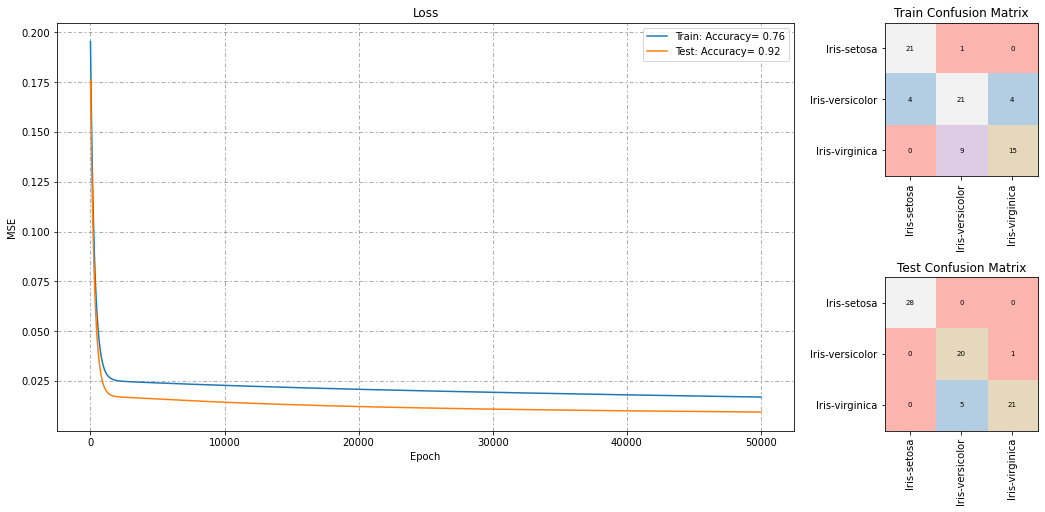

In [59]:
#import given data
given_data = pd.read_csv('iris.csv', header= None)
given_data = np.array(given_data)
#shuffling dataset
np.random.shuffle(given_data)
dataset = np.zeros(given_data.shape)
dataset[:, :4] = given_data[:, :4]
#changing target label to float label
dataset[:, 4][given_data[:, 4] == 'Iris-setosa'] = 1/6
dataset[:, 4][given_data[:, 4] == 'Iris-versicolor'] = 3/6
dataset[:, 4][given_data[:, 4] == 'Iris-virginica'] = 5/6

#keeping 50% of data for final test
split_ratio = 0.5
n = int(dataset.shape[0] * split_ratio)
train_data = dataset[:n]
test_data = dataset[n:]

#min-max normalizing
train_data_mm = np.zeros(train_data.shape)
test_data_mm = np.zeros(test_data.shape)
max_x = np.max(train_data[:, :4], axis= 0)
min_x = np.min(train_data[:, :4], axis= 0)
train_data_mm[:, :4] = (train_data[:, :4] - min_x) / (max_x - min_x)
train_data_mm[:, 4:] = train_data[:, 4:]
test_data_mm[:, :4] = (test_data[:, :4] - min_x) / (max_x - min_x)
test_data_mm[:, 4:] = test_data[:, 4:]
#z-score normalizing
train_data_zs = np.zeros(train_data.shape)
test_data_zs = np.zeros(test_data.shape)
mean_x = np.mean(train_data[:, :4], axis= 0)
std_x = np.std(train_data[:, :4], axis= 0)
train_data_zs[:, :4] = (train_data[:, :4] - mean_x) / std_x
train_data_zs[:, 4:] = train_data[:, 4:]
test_data_zs[:, :4] = (test_data[:, :4] - mean_x) / std_x
test_data_zs[:, 4:] = test_data[:, 4:]

#transposing dataset
X_train = train_data_zs.T[:4]
Y_train = train_data_zs.T[4:]
X_test = test_data_zs.T[:4]
Y_test = test_data_zs.T[4:]

#we defined the network w.r.t condition we are interested in
saeid = MLP_NN([4, 10, 1], ['sigmoid', 'iden'],
               eta_W= 0.0001, eta_B= 0.001, eta_a= 0.001, eta_g= 0.001,
               w_lower_limit= 0, w_upper_limit= 1, g_first= 1, a_first= 0.5)

#we set iteration number and batch size
epoch_size = 50000
#we difine two list to keep result of train
#and test dataset for each epoch in themm
loss_train = []
loss_test = []

#for each epoch
for epoch in range(epoch_size):
    #loss of test dataset
    #feed forward
    saeid.feed_fwd(X_test)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_test) ** 2) / Y_test.shape[1]
    #keeping test loss of epoch
    loss_test.append(loss)

    #loss of train dataset
    #feed forward
    saeid.feed_fwd(X_train)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_train) ** 2) / Y_train.shape[1]
    #keeping train loss of epoch
    loss_train.append(loss)
    
    #training on training dataset
    saeid.back_prog(Y_train)
    
#check network prediction on train dataset after training
saeid.feed_fwd(X_train)
predict = float_classify(saeid.Output[-1]).reshape(-1)
target = float_classify(Y_train).reshape(-1)
#correct datapoint
num_correct_points = sum(predict == target)
#accuracy
trained_acc_train = num_correct_points / Y_train.shape[1]
#confusion matrix
cm_train = confusion_matrix(target, predict)
#check network prediction on test dataset after training
saeid.feed_fwd(X_test)
predict = float_classify(saeid.Output[-1]).reshape(-1)
target = float_classify(Y_test).reshape(-1)
#correct datapoint
num_correct_points = sum(predict == target)
#accuracy
trained_acc_test = num_correct_points / Y_test.shape[1]
#confusion matrix
cm_test = confusion_matrix(target, predict)

#showing result
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
fig = plt.figure(constrained_layout=True, figsize=(15,7))
gs = GridSpec(2, 4, figure= fig)
ax = [0] * 3
#loss values
ax[0] = fig.add_subplot(gs[:, :-1])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_title('Loss')
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(loss_train, label= f'Train: Accuracy= {trained_acc_train}')
ax[0].plot(loss_test, label= f'Test: Accuracy= {trained_acc_test}')
ax[0].legend()
#train dataset confusion matrix
ax[1] = fig.add_subplot(gs[0,-1])
ax[1].imshow(cm_train, cmap="Pastel1")
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels, rotation= 90)
ax[1].set_yticklabels(labels)
ax[1].set_title('Train Confusion Matrix')
for p in range(len(cm_train[0])):
    for q in range(len(cm_train[1])):
        ax[1].text(q, p, cm_train[p, q], ha="center", va="center", color="k", size= 7)
#train dataset confusion matrix    
ax[2] = fig.add_subplot(gs[1,-1])
ax[2].imshow(cm_test, cmap="Pastel1")
ax[2].set_xticks(np.arange(len(labels)))
ax[2].set_yticks(np.arange(len(labels)))
ax[2].set_xticklabels(labels, rotation= 90)
ax[2].set_yticklabels(labels)
ax[2].set_title('Test Confusion Matrix')
for p in range(len(cm_test[0])):
    for q in range(len(cm_test[1])):
        ax[2].text(q, p, cm_test[p, q], ha="center", va="center", color="k", size= 7)

### Part .b

#### One-Hot Label
Here we import the given dataset and shuffle it to make it uniform in labels and change its label to one-hot form. Then use 50% of data for training the network and 50% of data for testing the trained network. Then we normalize all data based on trainig data with min-max and z-score method.

Here we choose normalized dataset and define our network. For this part we use z-score normalized dataset and set first_g = 1 and first_a = 0.5 and range of w (0~1). First layer (input layer) has 4 dimensions, second layer (hidden layer) has 10 dimensions and last layer (output layer) has 3 dimensions. Activation functions of second layer are tanh and last layer's function is identity.

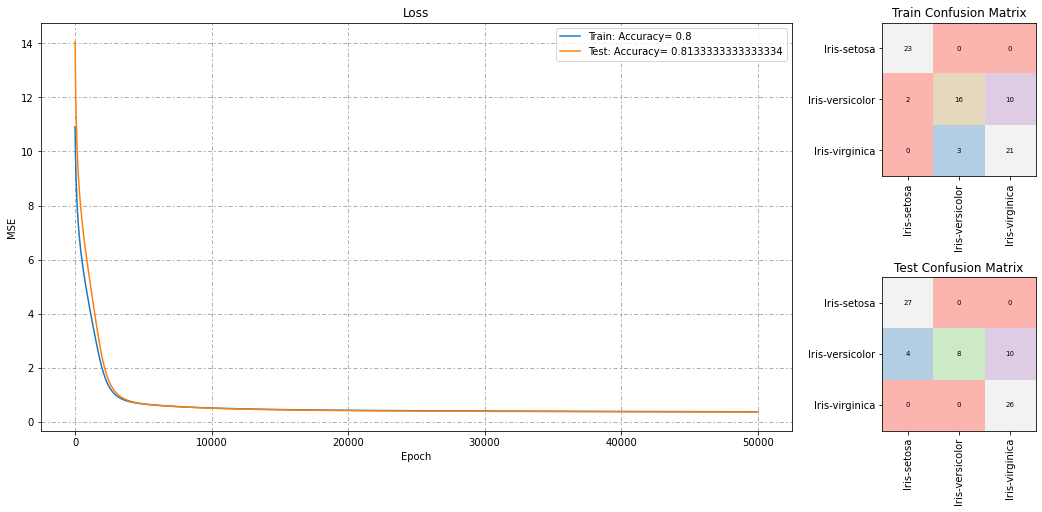

In [60]:
#import given data
given_data = pd.read_csv('iris.csv', header= None)
given_data = np.array(given_data)
#shuffling dataset
np.random.shuffle(given_data)
#changing target label to one-hot label
dataset = np.zeros([given_data.shape[0], given_data.shape[1] + 2])
dataset[:, :4] = given_data[:, :4]
dataset[:, 4][given_data[:, 4] == 'Iris-setosa'] = 1
dataset[:, 5][given_data[:, 4] == 'Iris-versicolor'] = 1
dataset[:, 6][given_data[:, 4] == 'Iris-virginica'] = 1

#keeping 50% of data for final test
split_ratio = 0.5
n = int(dataset.shape[0] * split_ratio)
train_data = dataset[:n]
test_data = dataset[n:]

#min-max normalizing
train_data_mm = np.zeros(train_data.shape)
test_data_mm = np.zeros(test_data.shape)
max_x = np.max(train_data[:, :4], axis= 0)
min_x = np.min(train_data[:, :4], axis= 0)
train_data_mm[:, :4] = (train_data[:, :4] - min_x) / (max_x - min_x)
train_data_mm[:, 4:] = train_data[:, 4:]
test_data_mm[:, :4] = (test_data[:, :4] - min_x) / (max_x - min_x)
test_data_mm[:, 4:] = test_data[:, 4:]
#z-score normalizing
train_data_zs = np.zeros(train_data.shape)
test_data_zs = np.zeros(test_data.shape)
mean_x = np.mean(train_data[:, :4], axis= 0)
std_x = np.std(train_data[:, :4], axis= 0)
train_data_zs[:, :4] = (train_data[:, :4] - mean_x) / std_x
train_data_zs[:, 4:] = train_data[:, 4:]
test_data_zs[:, :4] = (test_data[:, :4] - mean_x) / std_x
test_data_zs[:, 4:] = test_data[:, 4:]

#transposing dataset
X_train = train_data_zs.T[:4]
Y_train = train_data_zs.T[4:]
X_test = test_data_zs.T[:4]
Y_test = test_data_zs.T[4:]

#we defined the network w.r.t condition we are interested in
saeid = MLP_NN([4, 10, 3], ['tanh', 'iden'],
               eta_W= 0.00001, eta_B= 0.0001, eta_a= 0.001, eta_g= 0.001,
               w_lower_limit= 0, w_upper_limit= 1, g_first= 1, a_first= 0.5)

#we set iteration number and batch size
epoch_size = 50000
#we difine two list to keep result of train
#and test dataset for each epoch in themm
loss_train = []
loss_test = []

#for each epoch
for epoch in range(epoch_size):
    #loss of test dataset
    #feed forward
    saeid.feed_fwd(X_test)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_test) ** 2) / Y_test.shape[1]
    #keeping test loss of epoch
    loss_test.append(loss)

    #loss of train dataset
    #feed forward
    saeid.feed_fwd(X_train)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_train) ** 2) / Y_train.shape[1]
    #keeping train loss of epoch
    loss_train.append(loss)
    
    #training on training dataset
    saeid.back_prog(Y_train)
    
#check network prediction on train dataset after training
saeid.feed_fwd(X_train)
predict = onehot_classify(saeid.Output[-1]).reshape(-1)
target = onehot_classify(Y_train).reshape(-1)
#correct datapoint
num_correct_points = sum(predict == target)
#accuracy
trained_acc_train = num_correct_points / Y_train.shape[1]
#confusion matrix
cm_train = confusion_matrix(target, predict)
#check network prediction on test dataset after training
saeid.feed_fwd(X_test)
predict = onehot_classify(saeid.Output[-1]).reshape(-1)
target = onehot_classify(Y_test).reshape(-1)
#correct datapoint
num_correct_points = sum(predict == target)
#accuracy
trained_acc_test = num_correct_points / Y_test.shape[1]
#confusion matrix
cm_test = confusion_matrix(target, predict)

#showing result
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
fig = plt.figure(constrained_layout=True, figsize=(15,7))
gs = GridSpec(2, 4, figure= fig)
ax = [0] * 3
#loss values
ax[0] = fig.add_subplot(gs[:, :-1])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_title('Loss')
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(loss_train, label= f'Train: Accuracy= {trained_acc_train}')
ax[0].plot(loss_test, label= f'Test: Accuracy= {trained_acc_test}')
ax[0].legend()
#train dataset confusion matrix
ax[1] = fig.add_subplot(gs[0,-1])
ax[1].imshow(cm_train, cmap="Pastel1")
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels, rotation= 90)
ax[1].set_yticklabels(labels)
ax[1].set_title('Train Confusion Matrix')
for p in range(len(cm_train[0])):
    for q in range(len(cm_train[1])):
        ax[1].text(q, p, cm_train[p, q], ha="center", va="center", color="k", size= 7)
#train dataset confusion matrix    
ax[2] = fig.add_subplot(gs[1,-1])
ax[2].imshow(cm_test, cmap="Pastel1")
ax[2].set_xticks(np.arange(len(labels)))
ax[2].set_yticks(np.arange(len(labels)))
ax[2].set_xticklabels(labels, rotation= 90)
ax[2].set_yticklabels(labels)
ax[2].set_title('Test Confusion Matrix')
for p in range(len(cm_test[0])):
    for q in range(len(cm_test[1])):
        ax[2].text(q, p, cm_test[p, q], ha="center", va="center", color="k", size= 7)

### Part .c

#### One-Hot Label with Softmax
Here we import the given dataset and shuffle it to make it uniform in labels and change its label to one-hot form. Then use 50% of data for training the network and 50% of data for testing the trained network. Then we normalize all data based on trainig data with min-max and z-score method.

Here we choose normalized dataset and define our network. For this part we use z-score normalized dataset and set first_g = 1 and first_a = 0.5 and range of w (0~1). First layer (input layer) has 4 dimensions, second layer (hidden layer) has 10 dimensions and last layer (output layer) has 3 dimensions. Activation functions of second layer are tanh and last layer's function is identity with softmax.

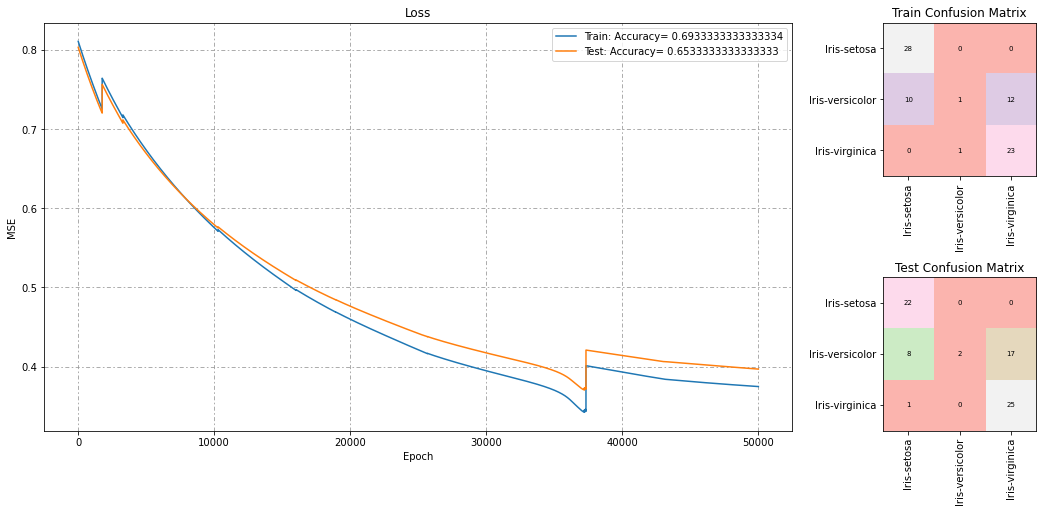

In [61]:
#import given data
given_data = pd.read_csv('iris.csv', header= None)
given_data = np.array(given_data)
#shuffling dataset
np.random.shuffle(given_data)
#changing target label to one-hot label
dataset = np.zeros([given_data.shape[0], given_data.shape[1] + 2])
dataset[:, :4] = given_data[:, :4]
dataset[:, 4][given_data[:, 4] == 'Iris-setosa'] = 1
dataset[:, 5][given_data[:, 4] == 'Iris-versicolor'] = 1
dataset[:, 6][given_data[:, 4] == 'Iris-virginica'] = 1

#keeping 50% of data for final test
split_ratio = 0.5
n = int(dataset.shape[0] * split_ratio)
train_data = dataset[:n]
test_data = dataset[n:]

#min-max normalizing
train_data_mm = np.zeros(train_data.shape)
test_data_mm = np.zeros(test_data.shape)
max_x = np.max(train_data[:, :4], axis= 0)
min_x = np.min(train_data[:, :4], axis= 0)
train_data_mm[:, :4] = (train_data[:, :4] - min_x) / (max_x - min_x)
train_data_mm[:, 4:] = train_data[:, 4:]
test_data_mm[:, :4] = (test_data[:, :4] - min_x) / (max_x - min_x)
test_data_mm[:, 4:] = test_data[:, 4:]
#z-score normalizing
train_data_zs = np.zeros(train_data.shape)
test_data_zs = np.zeros(test_data.shape)
mean_x = np.mean(train_data[:, :4], axis= 0)
std_x = np.std(train_data[:, :4], axis= 0)
train_data_zs[:, :4] = (train_data[:, :4] - mean_x) / std_x
train_data_zs[:, 4:] = train_data[:, 4:]
test_data_zs[:, :4] = (test_data[:, :4] - mean_x) / std_x
test_data_zs[:, 4:] = test_data[:, 4:]

#transposing dataset
X_train = train_data_zs.T[:4]
Y_train = train_data_zs.T[4:]
X_test = test_data_zs.T[:4]
Y_test = test_data_zs.T[4:]

#we defined the network w.r.t condition we are interested in
saeid = MLP_NN([4, 10, 3], ['tanh', 'iden'],
               eta_W= 0.0001, eta_B= 0.0001, eta_a= 0.001, eta_g= 0.001,
               w_lower_limit= 0, w_upper_limit= 1, g_first= 1, a_first= 0.5, SM= True)

#we set iteration number and batch size
epoch_size = 50000
#we difine two list to keep result of train
#and test dataset for each epoch in themm
loss_train = []
loss_test = []

#for each epoch
for epoch in range(epoch_size):
    #loss of test dataset
    #feed forward
    saeid.feed_fwd(X_test)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_test) ** 2) / Y_test.shape[1]
    #keeping test loss of epoch
    loss_test.append(loss)

    #loss of train dataset
    #feed forward
    saeid.feed_fwd(X_train)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_train) ** 2) / Y_train.shape[1]
    #keeping train loss of epoch
    loss_train.append(loss)
    
    #training on training dataset
    saeid.back_prog(Y_train)
    
#check network prediction on train dataset after training
saeid.feed_fwd(X_train)
predict = onehot_classify(saeid.Output[-1]).reshape(-1)
target = onehot_classify(Y_train).reshape(-1)
#correct datapoint
num_correct_points = sum(predict == target)
#accuracy
trained_acc_train = num_correct_points / Y_train.shape[1]
#confusion matrix
cm_train = confusion_matrix(target, predict)
#check network prediction on test dataset after training
saeid.feed_fwd(X_test)
predict = onehot_classify(saeid.Output[-1]).reshape(-1)
target = onehot_classify(Y_test).reshape(-1)
#correct datapoint
num_correct_points = sum(predict == target)
#accuracy
trained_acc_test = num_correct_points / Y_test.shape[1]
#confusion matrix
cm_test = confusion_matrix(target, predict)

#showing result
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
fig = plt.figure(constrained_layout=True, figsize=(15,7))
gs = GridSpec(2, 4, figure= fig)
ax = [0] * 3
#loss values
ax[0] = fig.add_subplot(gs[:, :-1])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_title('Loss')
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(loss_train, label= f'Train: Accuracy= {trained_acc_train}')
ax[0].plot(loss_test, label= f'Test: Accuracy= {trained_acc_test}')
ax[0].legend()
#train dataset confusion matrix
ax[1] = fig.add_subplot(gs[0,-1])
ax[1].imshow(cm_train, cmap="Pastel1")
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels, rotation= 90)
ax[1].set_yticklabels(labels)
ax[1].set_title('Train Confusion Matrix')
for p in range(len(cm_train[0])):
    for q in range(len(cm_train[1])):
        ax[1].text(q, p, cm_train[p, q], ha="center", va="center", color="k", size= 7)
#train dataset confusion matrix    
ax[2] = fig.add_subplot(gs[1,-1])
ax[2].imshow(cm_test, cmap="Pastel1")
ax[2].set_xticks(np.arange(len(labels)))
ax[2].set_yticks(np.arange(len(labels)))
ax[2].set_xticklabels(labels, rotation= 90)
ax[2].set_yticklabels(labels)
ax[2].set_title('Test Confusion Matrix')
for p in range(len(cm_test[0])):
    for q in range(len(cm_test[1])):
        ax[2].text(q, p, cm_test[p, q], ha="center", va="center", color="k", size= 7)